<a href="https://colab.research.google.com/github/MarcelMirT/AI-Policy.github.io/blob/main/workshops/optimizers/optimizers_normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Only execute on Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install packages
    %pip install einops jaxtyping typeguard

    # Code to make sure output widgets display
    from google.colab import output

    output.enable_custom_widget_manager()

    !wget -q https://github.com/EffiSciencesResearch/ML4G-2.0/archive/refs/heads/master.zip
    !unzip -o /content/master.zip 'ML4G-2.0-master/workshops/optimizers/*'
    !mv --no-clobber ML4G-2.0-master/workshops/optimizers/* .
    !rm -r ML4G-2.0-master

    print("Imports & installations complete!")

else:

    from IPython import get_ipython

    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.9 MB/s eta 0:00:00
Archive:  /content/master.zip
8cc8dfee7a1b35bc4888aff1bfde05597197c4fd
   creating: ML4G-2.0-master/workshops/optimizers/
  inflating: ML4G-2.0-master/workshops/optimizers/SGD_tests.py  
  inflating: ML4G-2.0-master/workshops/optimizers/optimizers.ipynb  
  inflating: ML4G-2.0-master/workshops/optimizers/optimizers_normal.ipynb  
Imports & installations complete!


<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G-2.0/blob/master/workshops/optimizers/optimizers_normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# Optimization

Today's material focuses on understanding the standard methods of optimisation in machine learning. You're going to learn about the training loop and different optimizers.

## Gradient Descent

In the preparation work, you have seen how backpropagation works. Today, we're going to use the gradients produced by backpropagation for optimizing a loss function using gradient descent.

A loss function can be any differentiable function such that we prefer a lower value. To apply gradient descent, we start by initializing the parameters to random values (the details of this are subtle), and then repeatedly compute the gradient of the loss with respect to the model parameters. It [can be proven](https://tutorial.math.lamar.edu/Classes/CalcIII/DirectionalDeriv.aspx) that for an infinitesimal step, moving in the direction of the gradient would increase the loss by the largest amount out of all possible directions.

We actually want to decrease the loss, so we subtract the gradient to go in the opposite direction. Taking infinitesimal steps is no good, so we pick some learning rate $\alpha$ (also called the step size) and scale our step by that amount to obtain the update rule for gradient descent:

$$\theta_{t+1} \leftarrow \theta_t - \alpha \cdot \nabla_\theta \text{Loss}(\theta_t)$$


## Hyperparameters

The learning rate is an example of a **hyperparameter**, which will be described below. As a reminder, a regular parameter is an adjustable value with the special and extremely convenient property that we can differentiate the loss with respect to the parameter, allowing us to efficiently learn good values for the parameter using gradient descent. In other words, the process of training is a function that takes a dataset, a model architecture, and a random seed and outputs model parameters.

The learning rate, in contrast, cannot be determined by this scheme. As a hyperparameter, we need to introduce an outer loop that wraps the training loop to search for good learning rate values. This outer loop is called a hyperparameter search, and each iteration consists of testing different combinations of hyperparameters using a dataset of pairs of $(\text{hyperparameters}, \text{validation performance})$. Obtaining results for each iteration (a single pair) requires running the inner training loop.

Due to a fixed budget of ML researcher time and available compute, we are interested in a trade-off between the ML researcher time, the cost of running the search, and the cost of training the final model. Due to the vast search space and cost of obtaining data, we don't hope to find any sort of optimum but merely to improve upon our initial guesses enough to justify the cost.

In addition, a hyperparameter isn't necessarily a single continuous value like the learning rate. Discrete unordered choices such as padding type as well as discrete ordered choices such as the number of layers in the network or the width of each convolution are all common. You will also need to choose between functions for optimizers, nonlinearities, or learning rate scheduling, of which there are an infinite number of possibilities, requiring us to select a small subset to test.

More broadly, every design decision can be considered a hyperparameter, including how to preprocess the input data, the connectivity of different layers, the types of operations, etc. Papers such as [AmeobaNet](https://arxiv.org/pdf/1801.01548.pdf) demonstrated that it's possible to find architectures superior to human-designed ones.

In the second part of today's material, you will learn about various strategies for searching over hyperparameters.

## Stochastic Gradient Descent

The terms gradient descent and SGD are used loosely in deep learning. To be technical, there are three variations:

- Batch gradient descent - the loss function is the loss over the entire dataset. This requires too much computation unless the dataset is small, so it is rarely used in deep learning.
- Stochastic gradient descent - the loss function is the loss on a randomly selected example. Any particular loss may be completely in the wrong direction of the loss on the entire dataset, but in expectation it's in the right direction. This has some nice properties but doesn't parallelize well, so it is rarely used in deep learning.
- Mini-batch gradient descent - the loss function is the loss on a batch of examples of size `batch_size`. This is the standard in deep learning.

The class `torch.SGD` can be used for any of these by varying the number of examples passed in. We will be using only mini-batch gradient descent in this course.

## Batch Size

In addition to choosing a learning rate or learning rate schedule, we need to choose the batch size or batch size schedule as well. Intuitively, using a larger batch means that the estimate of the gradient is closer to that of the true gradient over the entire dataset, but this requires more compute. Each element of the batch can be computed in parallel so with sufficient compute, one can increase the batch size without increasing wall-clock time. For small-scale experiments, a good heuristic is thus "fill up all of your GPU memory".

At a larger scale, we would expect diminishing returns of increasing the batch size, but empirically it's worse than that - a batch size that is too large generalizes more poorly in many scenarios. The intuition that a closer approximation to the true gradient is always better is therefore incorrect. See [this paper](https://arxiv.org/pdf/1706.02677.pdf) for one discussion of this.

For a batch size schedule, most commonly you'll see batch sizes increase over the course of training. The intuition is that a rough estimate of the proper direction is good enough early in training, but later in training it's important to preserve our progress and not "bounce around" too much.

You will commonly see batch sizes that are a multiple of 32. One motivation for this is that when using CUDA, threads are grouped into "warps" of 32 threads which execute the same instructions in parallel. So a batch size of 64 would allow two warps to be fully utilized, whereas a size of 65 would require waiting for a third warp to finish. As batch sizes become larger, this wastage becomes less important.

Powers of two are also common - the idea here is that work can be recursively divided up among different GPUs or within a GPU. For example, a matrix multiplication can be expressed by recursively dividing each matrix into four equal blocks and performing eight smaller matrix multiplications between the blocks.

## Computing Gradients in PyTorch

Recall that gradients are only saved for `Tensor`s for which `requires_grad=True`. For convenience, `nn.Parameter` automatically sets `requires_grad=True` on the wrapped `Tensor`. As you call `torch` functions, PyTorch tracks the relevant information needed in case you call `backward` later on, at which point it does the actual computation to compute the gradient and stores it in the `Tensor`'s `grad` field.

Also recall that PyTorch accumulates gradients across multiple `backward` calls. So if your tensor's `grad` already contains a value, after calling `backward` again it will have the sum of the original value and the new gradient. This behavior comes in handy in many situations, such as computing gradients over multiple runs on a GPU as part of a single batch. Suppose you choose a batch size of 32, but only 8 inputs fit on your GPU. A typical loss function for a batch computes the sum of losses over each example, so you can compute the losses 8 at a time and sum their gradients, producing the same result as running all 32 inputs at once.

### Stopping gradients with `torch.no_grad` or `torch.inference_mode`

You may not want PyTorch to track gradients for some computations despite involving tensors with `requires_grad=True`. In this case, you can wrap the computation in the `with torch.inference_mode()` context to prevent this tracking.


In this notebook, we will discuss the most popular optimizers used in training neural networks. You will implement optimizers from simple to compex:
- Stochastic Gradient Descent (SGD)
- SGD with Momentum
- RMSprop
- Adam

> ## Learning Objectives
> - Understand what optimizers are and why they are used
> - Get an intuition for momentum and RMS
> - Understand what the different hyperparameters in Adam are and how they affect the training process


In [23]:
import torch
from torch import Tensor
from jaxtyping import Float, jaxtyped
import typeguard
from SGD_tests import test_SGD, test_momentum, test_RMSprop, test_Adam, plot_rosenbrock
import matplotlib.pyplot as plt
import numpy as np

typechecked = jaxtyped(typechecker=typeguard.typechecked)

The job of an optimizer is to find the minimum in a Loss funciton. The loss function we are going to consider here is Rosenbrocks Banana function.
Of course, in practice, loss funcitons are very high dimensional and not so simple. But we have an easier time plotting 2D functions.

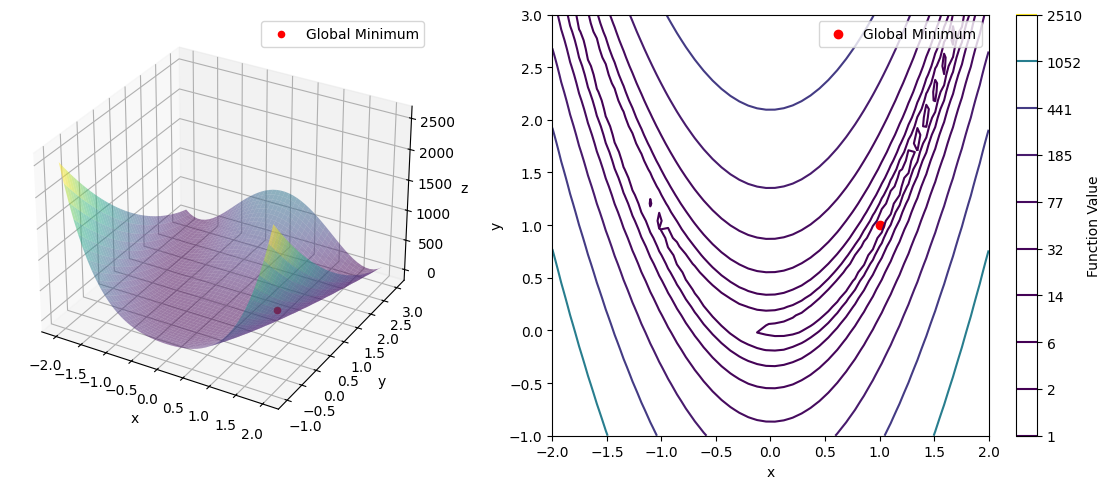

In [5]:
def rosenbrocks_banana(x: Tensor, y: Tensor, a=1, b=100) -> Tensor:
    return (a - x) ** 2 + b * (y - x**2) ** 2 + 1


plot_rosenbrock();

### Exercise - Implementing the training loop and Stochastic Gradient Descent (SGD) optimizer
(2-5 mins)

The training loop consists of the following steps:
- Compute the loss
- Compute the gradients
- Update the parameters
- Zero the gradients

The update rule for Stochastic Gradient Descent (SGD) is given by:

$$\theta_{t+1} = \theta_t - \alpha \cdot \nabla_\theta \text{Loss}(\theta_t)$$

where:
- $\theta_t$ represents the model's **parameters** at iteration $t$.
- $\alpha$ is the **learning rate**, which determines the step size of the parameter updates.
- $\nabla_\theta \text{Loss}(\theta_t)$ denotes the **gradient of the loss function** $\text{Loss}$ with respect to the parameters $\theta_t$.

Note: If you are stuck for too long, call a TA, or look at (part of) the solution. You can expand the "Solution" toggle after each exercise.

In [9]:
def optimize_function(
    function: callable, parameters: Float[Tensor, "xy=2"], optimizer, n_steps: int
) -> Float[Tensor, "n_steps xy=2"]:
    """
    Optimize a function using the given optimizer for n_steps steps.

    Args:
    - function (callable): The function to optimize. For example, `rosenbrocks_banana`.

    """
    trajectory = []
    for _ in range(n_steps):
        trajectory.append(parameters.detach().clone())
        loss = function(*parameters)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    trajectory = torch.stack(trajectory).float()
    return trajectory


class StocasticGradientDescent:
    def __init__(self, parameters: Tensor, learning_rate: float):
        self.parameters = parameters  # theta
        self.learning_rate = learning_rate  # alpha

    def step(self):
        with torch.no_grad():
            self.parameters -= self.learning_rate * self.parameters.grad # TODO: ~7 words


    def zero_grad(self):
        self.parameters.grad = None


test_SGD(StocasticGradientDescent)

SGD test passed


<details>
<summary>Show solution</summary>

```python
def optimize_function(
    function: callable, parameters: Float[Tensor, "xy=2"], optimizer, n_steps: int
) -> Float[Tensor, "n_steps xy=2"]:
    """
    Optimize a function using the given optimizer for n_steps steps.

    Args:
    - function (callable): The function to optimize. For example, `rosenbrocks_banana`.

    """
    trajectory = []
    for _ in range(n_steps):
        trajectory.append(parameters.detach().clone())
        loss = function(*parameters)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    trajectory = torch.stack(trajectory).float()
    return trajectory


class StocasticGradientDescent:
    def __init__(self, parameters: Tensor, learning_rate: float):
        self.parameters = parameters  # theta
        self.learning_rate = learning_rate  # alpha

    def step(self):
        with torch.no_grad():
            self.parameters -= self.learning_rate * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad = None


test_SGD(StocasticGradientDescent)
```

</details>



Let's examine the trajectory your optimizer follows in the parameter space! Does it appear sensible? Is it effective?

You can experiment for a few minutes with the learning rate to observe how it influences the trajectory.

**Note:** If you observe a straight line in the plot, it indicates that the learning rate is too high and the optimization is diverging.

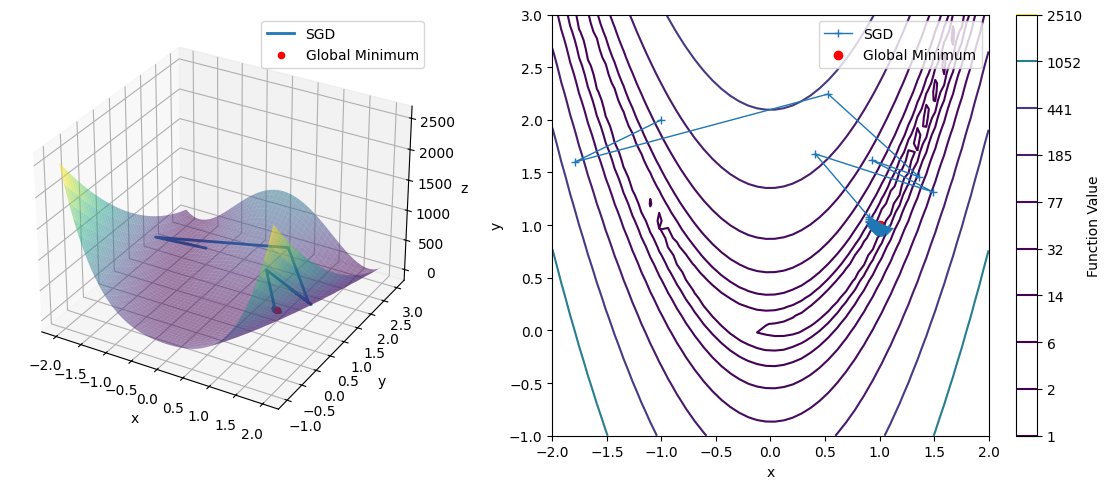

In [13]:
parameters = torch.tensor([-1.0, 2.0], requires_grad=True)

N_steps = 100
learning_rate = 0.002
optimizer = StocasticGradientDescent(parameters, learning_rate)

trajectories = {}
trajectories["SGD"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories);

### Exercise - Implement the training loop and Stochastic Gradient Descent with Momentum optimizer
(2-5 mins)

When we have momentum in our optimizer, we additionally keep track of the "velocity" with which we are currently moving $a_t$. The update rule for Stochastic Gradient Descent with Momentum is given by:

$$a_{t+1} = \mu \cdot a_t + (1 - \mu) \cdot \nabla_\theta \text{Loss}(\theta_t)$$
$$\theta_{t+1} = \theta_t - \alpha \cdot a_{t+1}$$

where:
- $\mu$ is the **momentum parameter**, which determines how much of the previous velocity we keep.
- $a_t$ represents the **running average** of the velocity at iteration $t$.
- $\alpha$ is the **learning rate**, which determines the step size of the parameter updates.

In [20]:
class Momentum:
    def __init__(self, parameters: Tensor, learning_rate: float, momentum: float):
        self.parameters = parameters  # theta
        self.learning_rate = learning_rate  # alpha
        self.momentum = momentum  # TODO: ~4 words
        self.average_grad = torch.zeros_like(parameters)

    def step(self):
        with torch.no_grad():
            self.average_grad = (self.momentum * self.average_grad + (1 - self.momentum) * self.parameters.grad)
            self.parameters -= self.learning_rate * self.average_grad # TODO: ~18 words


    def zero_grad(self):
        self.parameters.grad = None


test_momentum(Momentum)

Momentum test passed


<details>
<summary>Show solution</summary>

```python
class Momentum:
    def __init__(self, parameters: Tensor, learning_rate: float, momentum: float):
        self.parameters = parameters  # theta
        self.learning_rate = learning_rate  # alpha
        self.momentum_parameter = momentum  # mu
        self.average_grad = torch.zeros_like(parameters)

    def step(self):
        with torch.no_grad():
            self.average_grad = (
                self.momentum_parameter * self.average_grad
                + (1 - self.momentum_parameter) * self.parameters.grad
            )
            self.parameters -= self.learning_rate * self.average_grad

    def zero_grad(self):
        self.parameters.grad = None


test_momentum(Momentum)
```

</details>



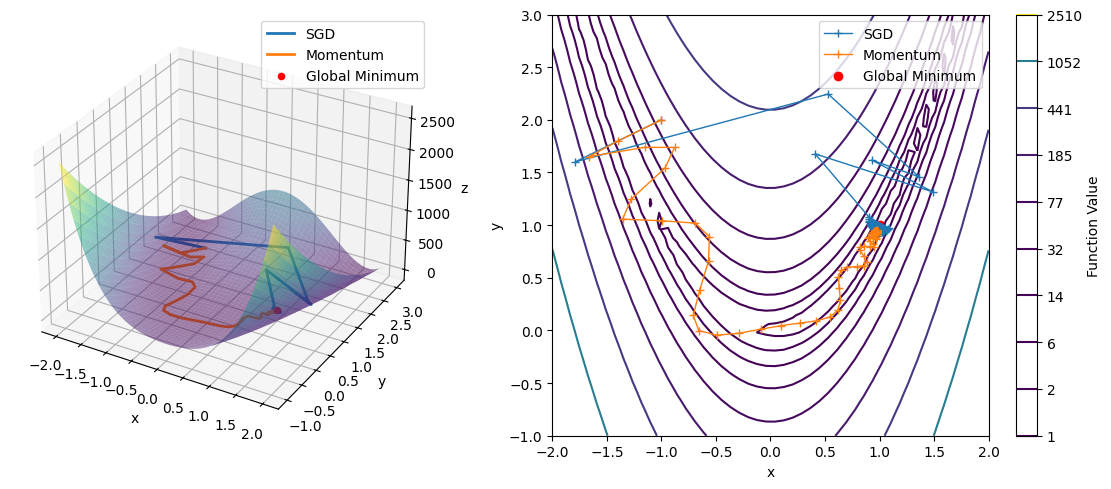

In [21]:
parameters = torch.tensor([-1.0, 2.0], requires_grad=True)
N_steps = 100
learning_rate = 0.01
momentum = 0.9
optimizer = Momentum(parameters, learning_rate, momentum)
trajectories["Momentum"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories);

## Note about Bonus Exercises

The following two exercises are similar to the last two. They introduce one new idea in RMSprop, and the Adam algorithm that combines RMSprop and momentum. Adam is the most popular optimizer in deep learning.

Skip those ercises, and come back to them only if you have time. Instead, run the cell below to use pytorch implementation rather than yours.
Then, go to the last exercise to play with hyperparameters. It's fun and it will help you build intuition about how they affect the training process.

In [22]:
from torch.optim import RMSprop, Adam

### Bonus Exercise - Implement RMSprop optimizer
(2-5 mins)

GPT4 explaining RMSprop: Imagine you're hiking up a mountain with a bumpy path. If you take big, uniform steps, you might trip or miss the best route. RMSprop helps by adjusting your step size based on the terrain: smaller steps on rough patches (steep gradients) and bigger steps on smoother areas (gentle gradients). This way, you can reach the top more efficiently and avoid stumbling.

RMSprop is an optimizer that adapts the learning rate for each parameter. To do that, we keep track of the moving average of the squared gradients $r_t$ and update the parameters as follows:

$$r_{t+1} = \mu \cdot r_t + (1 - \mu) \cdot \nabla_\theta \text{Loss}(\theta_t)^2$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{r_{t+1} + \epsilon}} \cdot \nabla_\theta \text{Loss}(\theta_t)$$

where:
- $\mu$ is the **momentum parameter**, which determines how much of the previous squared gradients we keep.
- $r_t$ represents the **moving average** of the squared gradients at iteration $t$.
- $\epsilon$ is a small value added to the denominator to avoid division by zero.

When the variance of gradients is high, we reduce the learning rate as we want to be more conservative. And when the variance of gradients is low, we increase the learning rate, thus going faster towards the optima.

In [27]:
class RMSprop:
    def __init__(self, parameters: Tensor, learning_rate: float, momentum: float, epsilon: float):
        self.parameters = parameters  # theta
        self.learning_rate = learning_rate  # alpha
        self.momentum_parameter = momentum  # mu
        self.epsilon = epsilon
        self.average_grad = torch.zeros_like(parameters) # TODO: ~5 words

    @torch.no_grad()
    def step(self):
      self.average_grad = self.momentum_parameter * self.average_grad + (1 - self.momentum_parameter) * self.parameters.grad **2
      self.parameters -= (self.learning_rate / (self.average_grad + self.epsilon) ** (1/2)) * self.parameters.grad # TODO: ~26 words

    def zero_grad(self):
        self.parameters.grad = None


test_RMSprop(RMSprop)

RMSprop test passed


<details>
<summary>Show solution</summary>

```python
class RMSprop:
    def __init__(self, parameters: Tensor, learning_rate: float, momentum: float, epsilon: float):
        self.parameters = parameters  # theta
        self.learning_rate = learning_rate  # alpha
        self.momentum_parameter = momentum  # mu
        self.epsilon = epsilon
        self.average_squared_grad = torch.zeros_like(parameters)

    @torch.no_grad()
    def step(self):
        self.average_squared_grad = (
            self.momentum_parameter * self.average_squared_grad
            + (1 - self.momentum_parameter) * self.parameters.grad**2
        )
        self.parameters -= (
            self.learning_rate
            * self.parameters.grad
            / (torch.sqrt(self.average_squared_grad + self.epsilon))
        )

    def zero_grad(self):
        self.parameters.grad = None


test_RMSprop(RMSprop)
```

</details>



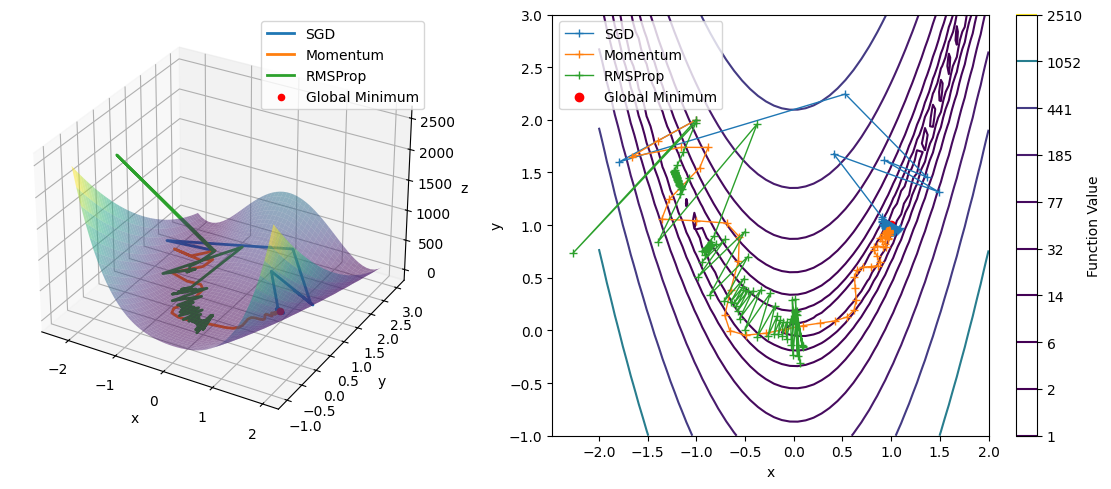

In [33]:
parameters = torch.tensor([-1.0, 2.0], requires_grad=True)
N_steps = 100
learning_rate = 0.4
momentum = 0.9
epsilon = 1e-8
if RMSprop is torch.optim.RMSprop:
    # If you skiped the exercise, the built-in optimizer needs a list of parameters, not a single tensor
    optimizer = RMSprop([parameters], learning_rate, momentum, epsilon)
else:
    optimizer = RMSprop(parameters, learning_rate, momentum, epsilon)
trajectories["RMSProp"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)

plot_rosenbrock(trajectories);

### Bonus Exercise - Implement Adam optimizer
(2-5 mins)

For the Adam optimizer, we now bring both momentum and RMSprop together. We keep track of the moving average of the gradients $a_t$ and the moving average of the squared gradients $r_t$ and update the parameters as follows:

$$a_{t+1} = \mu_1 \cdot a_t + (1 - \mu_1) \cdot \nabla_\theta \text{Loss}(\theta_t)$$
$$r_{t+1} = \mu_2 \cdot r_t + (1 - \mu_2) \cdot \nabla_\theta \text{Loss}(\theta_t)^2$$
$$\hat{a}_{t+1} = \frac{a_{t+1}}{1 - \mu_1^{t+1}}$$
$$\hat{r}_{t+1} = \frac{r_{t+1}}{1 - \mu_2^{t+1}}$$

$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat{r}_{t+1} + \epsilon}} \cdot \hat{a}_{t+1}$$

where:
- $\mu_1$ and $\mu_2$ are the **momentum parameters** for the gradients and squared gradients, respectively.
- $a_t$ and $r_t$ represent the **moving averages** of the gradients and squared gradients at iteration $t$.
- $\hat{a}_{t+1}$ and $\hat{r}_{t+1}$ are the **bias-corrected** moving averages.
- $\epsilon$ is a small value added to the denominator to avoid division by zero.


In [38]:
class Adam:
    def __init__(
        self,
        parameters: Tensor,
        learning_rate: float,
        momentum_grad: float,
        momentum_grad_squared: float,
        epsilon: float,
    ):
        self.parameters = parameters  # theta
        self.learning_rate = learning_rate  # alpha
        self.epsilon = epsilon
        self.momentum_grad = momentum_grad
        self.momentum_grad_squared = momentum_grad_squared
        self.A_average_grad = torch.zeros_like(parameters) # TODO: ~21 words
        self.R_average_grad = torch.zeros_like(parameters)
        self.T = 0

    @torch.no_grad()
    def step(self):
      self.T += 1
      self.A_average_grad = self.momentum_grad * self.A_average_grad + (1 - self.momentum_grad) * self.parameters.grad
      self.R_average_grad = self.momentum_grad_squared * self.R_average_grad + (1 - self.momentum_grad_squared) * self.parameters.grad **2
      bias_a = self.A_average_grad / (1 - self.momentum_grad **self.T)
      bias_b = self.R_average_grad / (1 - self.momentum_grad_squared **self.T)
      self.parameters -= self.learning_rate * bias_a / (bias_b.sqrt() + self.epsilon)
      #self.parameters -= self.learning_rate * self.A_average_grad / (self.R_average_grad + self.epsilon) ** (1/2) # TODO: ~54 words

    def zero_grad(self):
        self.parameters.grad = None


test_Adam(Adam)

Adam test passed


<details>
<summary>Show solution</summary>

```python
class Adam:
    def __init__(
        self,
        parameters: Tensor,
        learning_rate: float,
        momentum_grad: float,
        momentum_grad_squared: float,
        epsilon: float,
    ):
        self.parameters = parameters  # theta
        self.learning_rate = learning_rate  # alpha
        self.epsilon = epsilon
        self.momentum_grad = momentum_grad  # mu_1
        self.momentum_grad_squared = momentum_grad_squared  # mu_2
        self.average_grad = torch.zeros_like(parameters)
        self.average_squared_grad = torch.zeros_like(parameters)
        self.t = 0

    @torch.no_grad()
    def step(self):
        self.t += 1
        self.average_grad = (
            self.momentum_grad * self.average_grad + (1 - self.momentum_grad) * self.parameters.grad
        )
        self.average_squared_grad = (
            self.momentum_grad_squared * self.average_squared_grad
            + (1 - self.momentum_grad_squared) * self.parameters.grad**2
        )
        average_grad_hat = self.average_grad / (1 - self.momentum_grad**self.t)
        average_squared_grad_hat = self.average_squared_grad / (
            1 - self.momentum_grad_squared**self.t
        )
        self.parameters -= (
            self.learning_rate
            * average_grad_hat
            / (torch.sqrt(average_squared_grad_hat + self.epsilon))
        )

    def zero_grad(self):
        self.parameters.grad = None


test_Adam(Adam)
```

</details>



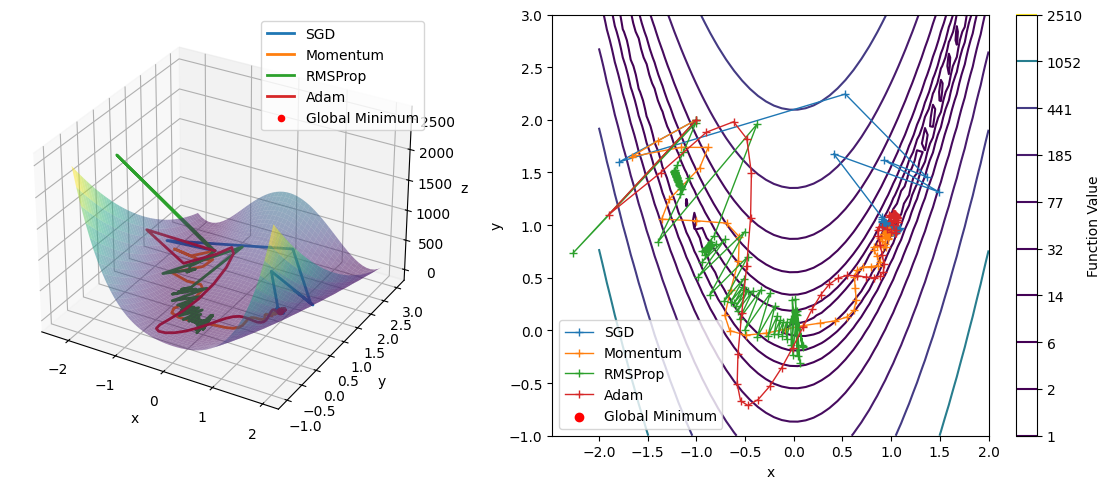

In [39]:
parameters = torch.tensor([-1.0, 2.0], requires_grad=True)

N_steps = 100
learning_rate = 0.9
mu1 = 0.9
mu2 = 0.999
epsilon = 1e-8
if Adam is torch.optim.Adam:
    # If you skiped the exercise, the built-in optimizer needs a list of parameters, not a single tensor
    optimizer = Adam([parameters], learning_rate, (mu1, mu2), epsilon)
else:
    optimizer = Adam(parameters, learning_rate, mu1, mu2, epsilon)

trajectories["Adam"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories);

### Exercise - Play around with the hyperparameters

Play around with learning rates, the betas, and epsilon.

Challenge until time is up: get within a 1e-2 range of the minimum of the banana function in as few steps as possible.